In [46]:
import pandas as pd
import matplotlib

data = pd.read_csv('Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016_v1.csv')
data['product_id'] = 'product_01'
print(data)

data.to_csv('Uniqlo\(FastRetailing\) 2012-2016 Training - stocks2012-2016_Header_v1.csv', index=False)

data_import = pd.DataFrame()
data_import['timestamp'] = data['timestamp']
data_import['item_id'] = data['item_id']
data_import['volume'] = data['Volume']
data_import['sku'] = 'product_1'
print(data_import)
#data_import.to_csv('Uniqlo(FastRetailing) 2012-2016 Training - stocks2012-2016_v2.csv')

In [47]:
# Historical Sales and Active Inventory

data = pd.read_csv('HistoricalSalesandActive Inventory.csv')
print(data.info())

print(data['date'].max())
print(data['date'].min())

print(data['store'].unique())
print(data['item'].unique())

print(data.head())

#filtering use 5 store, 20 item/sku and 1 years date
data = data[(data['date'] > '2017-01-01') & (data['date'] < '2017-12-31')]
data = data[(data['item'] >0) & (data['item']< 6)]
data = data[data['store'] == 1]
print(len(data))

# data.to_csv('HistoricalSalesandActive Inventory_no_header.csv', header=False, index=False)
# data.to_csv('HistoricalSalesandActive Inventory.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB
None
2017-12-31
2013-01-01
[ 1  2  3  4  5  6  7  8  9 10]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
         date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10
1815


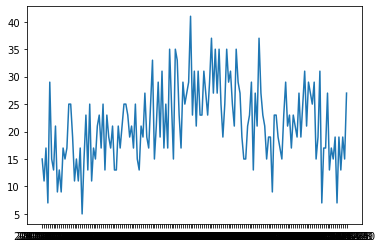

<Figure size 576x144 with 0 Axes>

In [48]:
#Visualize demand sales 
import matplotlib.pyplot as plt
%matplotlib inline
filter_data = data[ (data['store'] == 1) & (data['item'] == 1) & (data['sales'])] 
# filter_data = filter_data[(filter_data['date'] > '2017-01-01') & (filter_data['date'] < '2017-01-31')]
x = filter_data['date'] 
y = filter_data['sales']  
plt.plot(x, y)
plt.figure(figsize=(8, 2))
plt.show()

In [49]:
# evaluate an ARIMA model using a walk-forward validation
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [50]:
#univariate dataset only use sales collumn
# split into train and test sets
X = filter_data['sales'].values
size = int(len(X) * 0.66)
print(size)
train, test = X[0:size], X[size:len(X)]
print(len(train))
print(len(test))
    #convert to array 
history = [x for x in train]
predictions = list()

106
106
55


In [51]:
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=27.664020, expected=15.000000
predicted=25.827179, expected=15.000000
predicted=20.878671, expected=21.000000
predicted=18.906909, expected=23.000000
predicted=18.675360, expected=29.000000
predicted=20.487645, expected=13.000000
predicted=20.892108, expected=27.000000
predicted=21.260870, expected=21.000000
predicted=23.033204, expected=37.000000
predicted=23.745671, expected=27.000000
predicted=26.252528, expected=23.000000
predicted=26.436794, expected=21.000000
predicted=26.023757, expected=15.000000
predicted=24.908149, expected=19.000000
predicted=21.260874, expected=19.000000
predicted=19.885271, expected=9.000000
predicted=17.102084, expected=23.000000
predicted=15.950657, expected=23.000000
predicted=19.031155, expected=19.000000
predicted=19.017533, expected=17.000000
predicted=18.173480, expected=15.000000
predicted=18.906009, expected=23.000000
predicted=19.118460, expected=29.000000
predicted=20.929886, expected=21.000000
predicted=21.456903, expected=23.000000
p

Test RMSE: 6.632


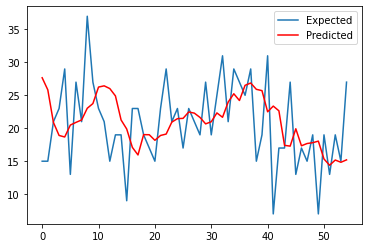

In [52]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test, label='Expected')
plt.plot(predictions, label='Predicted', color='red')
plt.legend()
plt.show()

In [53]:
# xgboost
from xgboost import XGBRegressor
import numpy
from sklearn.metrics import mean_absolute_error

In [54]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

[[ 1.  1. 15. ...  1.  1. 13.]
 [ 1.  1. 11. ...  1.  1. 21.]
 [ 1.  1. 17. ...  1.  1.  9.]
 ...
 [ 1.  1. 17. ...  1.  1. 19.]
 [ 1.  1. 15. ...  1.  1. 15.]
 [ 1.  1. 19. ...  1.  1. 27.]]
102
>expected=21.0, predicted=16.2
>expected=23.0, predicted=18.4
>expected=29.0, predicted=20.2
>expected=13.0, predicted=20.7
>expected=27.0, predicted=13.7
>expected=21.0, predicted=20.9
>expected=37.0, predicted=21.4
>expected=27.0, predicted=24.7
>expected=23.0, predicted=26.4
>expected=21.0, predicted=28.2
>expected=15.0, predicted=33.2
>expected=19.0, predicted=19.3
>expected=19.0, predicted=20.3
>expected=9.0, predicted=20.4
>expected=23.0, predicted=19.7
>expected=23.0, predicted=16.1
>expected=19.0, predicted=17.8
>expected=17.0, predicted=17.5
>expected=15.0, predicted=18.8
>expected=23.0, predicted=17.3
>expected=29.0, predicted=18.4
>expected=21.0, predicted=21.0
>expected=23.0, predicted=21.0
>expected=17.0, predicted=18.4
>expected=23.0, predicted=25.4
>expected=21.0, predicted=20.6

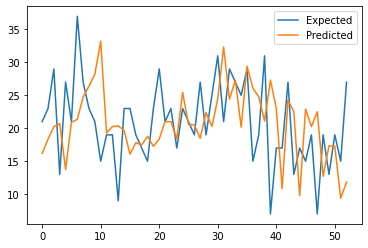

In [56]:
# transform the time series data into supervised learning
def xgboost_forecast(train, testX):
	# transform list into array
	train = numpy.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data):
	predictions = list()
	# split dataset
	size = int(len(data) * 0.66)
	print(size)
	train, test = data[0:size], data[size:len(data)]
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	# error = mean_absolute_error(test[:, -1], predictions)
	error = sqrt(mean_squared_error(test[:, -1], predictions))
	
	return error, test[:, -1], predictions

# load the dataset
series = filter_data.loc[:, filter_data.columns != 'date']
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
print(data)
# evaluate
error, y, yhat = walk_forward_validation(data)
print('RMSE: %.3f' % error)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()